In [1]:
import os
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.mixed_precision import set_global_policy

2024-12-31 22:45:03.454547: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-31 22:45:03.516442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 22:45:03.516489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 22:45:03.517973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 22:45:03.528432: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Enable mixed precision
policy = 'mixed_float16'
set_global_policy(policy)
print(f"Mixed precision enabled with policy: {policy}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # 4GB limit
            )
    except RuntimeError as e:
        print(f"Failed to set virtual device configuration: {e}")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6
Mixed precision enabled with policy: mixed_float16


2024-12-31 22:27:19.235155: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 22:27:19.327355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 22:27:19.327436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-31 22:27:19.328442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf


In [3]:
import sys
# Add the scripts folder to the system path
scripts_path = os.path.abspath(os.path.join('..', 'scripts/python'))
sys.path.append(scripts_path)


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
from utils import (
    create_transformer_for_classical_style,
    train_transformer_for_classical_style,
    create_diffusion_model,
    train_diffusion_for_classical_style,
    generate_classical_poem
)

# Configure visualization settings
%matplotlib inline


In [5]:

# Define Paths
processed_data_path = '../data/processed/processed_taweel_data.csv'
diffusion_output_dir = '../models/diffusion'
transformer_output_dir = '../models/transformers'

os.makedirs(diffusion_output_dir, exist_ok=True)
os.makedirs(transformer_output_dir, exist_ok=True)

# Load and Inspect Data
print("Loading processed data...")
processed_df = pd.read_csv(processed_data_path, encoding='utf-8-sig')
print(f"Processed data loaded with {len(processed_df)} records.")

# Subset for Quick Testing (Optional)
subset = True
if subset:
    print("Using subset for testing...")
    train_df, valid_df = train_test_split(processed_df, test_size=0.2, random_state=42)
    train_subset = train_df.sample(n=100, random_state=42)  # Adjust as needed
    valid_subset = valid_df.sample(n=20, random_state=42)
else:
    train_df, valid_df = train_test_split(processed_df, test_size=0.2, random_state=42)
    train_subset, valid_subset = train_df, valid_df

print(f"Training records: {len(train_subset)}; Validation records: {len(valid_subset)}")


Loading processed data...
Processed data loaded with 103441 records.
Using subset for testing...
Training records: 100; Validation records: 20


In [9]:
# ------------------------ #
# 1. Train the Transformer  #
# ------------------------ #

print("Training Transformer in auto-encoder style for classical poems...")
tokenizer_name = "t5-small"  # Use a Seq2Seq model
tok = AutoTokenizer.from_pretrained(tokenizer_name)

# Create the Transformer Model
transformer_model = create_transformer_for_classical_style(model_name=tokenizer_name, max_length=128)

# Prepare Training Data
sub_df = train_subset[['text']].copy()

# Train the Transformer
trained_transformer, hist = train_transformer_for_classical_style(
    df_classical=sub_df,
    tokenizer=tok,
    model=transformer_model,
    max_length=128,
    epochs=3,           # Adjust epochs as needed
    batch_size=2,       # Adjust batch size based on GPU memory
    output_dir=transformer_output_dir
)
print("Transformer training complete.")

Training Transformer in auto-encoder style for classical poems...


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/3
40/40 [==============================] - 63s 378ms/step - loss: 4.6997 - accuracy: 0.5715 - val_loss: 0.1262 - val_accuracy: 0.9844
Epoch 2/3
40/40 [==============================] - 11s 266ms/step - loss: 0.3111 - accuracy: 0.9475 - val_loss: 0.1435 - val_accuracy: 0.9844
Epoch 3/3
40/40 [==============================] - 9s 229ms/step - loss: 0.1702 - accuracy: 0.9737 - val_loss: 0.1183 - val_accuracy: 0.9844
Transformer training complete.


In [14]:
# Save the final Transformer model
final_model_path = os.path.join(transformer_output_dir, "auto_encoder_transformer_model_final.h5")
trained_transformer.save_weights(final_model_path)
print(f"Final Transformer model saved to {final_model_path}")

# Save the tokenizer correctly
tokenizer_output_path = os.path.join(transformer_output_dir, "tokenizer")
tok.save_pretrained(tokenizer_output_path)
print(f"Tokenizer saved to {tokenizer_output_path}")

Final Transformer model saved to ../models/transformers/auto_encoder_transformer_model_final.h5
Tokenizer saved to ../models/transformers/tokenizer


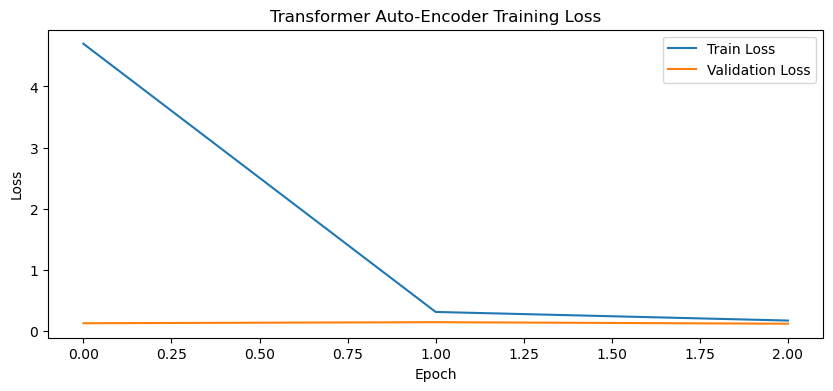

In [10]:
# Plot Transformer Training History
plt.figure(figsize=(10, 4))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title("Transformer Auto-Encoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

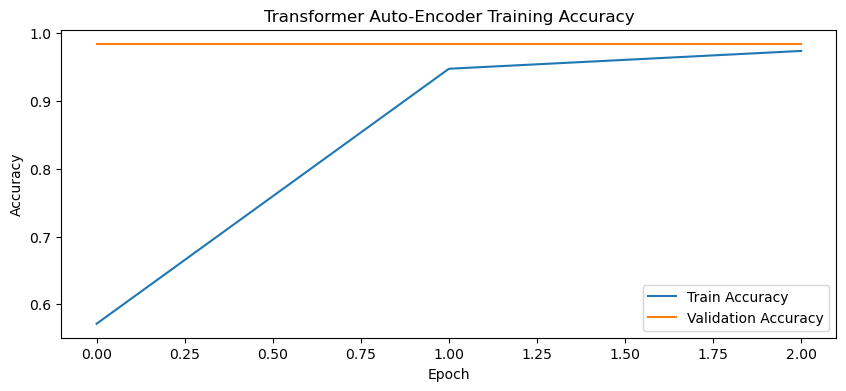

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title("Transformer Auto-Encoder Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [7]:
# ------------------------ #
# 2. Train the Diffusion    #
# ------------------------ #

import numpy as np

print("Creating diffusion model...")
# Define Diffusion Model Parameters
tokenizer_name = "t5-small"  # Use a Seq2Seq model
tok = AutoTokenizer.from_pretrained(tokenizer_name)

max_length = 128
max_bayt_len = 128
encoding_dim = 8
diffusion_model_params = {
    'num_transformer_blocks': 4,
    'num_heads': 8,
    'key_dim': 64,
    'ffn_units': 512
}

# Create Diffusion Model
input_shape = (max_bayt_len, encoding_dim)
diffusion_model = create_diffusion_model(input_shape, diffusion_model_params)

# Train Diffusion Model
batch_size = 8
epochs = 5
print("Training diffusion model...")
trained_diffusion_model, diffusion_hist = train_diffusion_for_classical_style(
    df_classical=train_subset,
    diffusion_model=diffusion_model,
    tokenizer=tok,
    max_length=max_length,
    max_bayt_len=max_bayt_len,
    encoding_dim=encoding_dim,
    epochs=epochs,
    batch_size=batch_size,
    output_dir=diffusion_output_dir
)
print("Diffusion model training complete.")


Creating diffusion model...
Model: "DiffusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 diffusion_input (InputLaye  [(None, 128, 8)]             0         []                            
 r)                                                                                               
                                                                                                  
 batch_normalization_9 (Bat  (None, 128, 8)               32        ['diffusion_input[0][0]']     
 chNormalization)                                                                                 
                                                                                                  
 multi_head_attention_4 (Mu  (None, 128, 8)               17928     ['batch_normalization_9[0][0]'
 ltiHeadAttention)                                       

2024-12-31 22:28:28.281266: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f22f9983400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-31 22:28:28.281359: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-12-31 22:28:28.291092: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-31 22:28:28.318623: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1735702108.420666   53436 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 9/10 [==========================>...] - ETA: 0s - loss: 1.3107 - mae: 0.6838  
Epoch 1: val_mae improved from inf to 1.66082, saving model to ../models/diffusion/diff_ckpt
INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


10/10 [==============================] - 24s 1s/step - loss: 1.2556 - mae: 0.6621 - val_loss: 4.8416 - val_mae: 1.6608
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.6343 - mae: 0.4827
Epoch 2: val_mae did not improve from 1.66082
10/10 [==============================] - 1s 61ms/step - loss: 0.6343 - mae: 0.4827 - val_loss: 6.6573 - val_mae: 2.2378
Epoch 3/5
 9/10 [==========================>...] - ETA: 0s - loss: 0.4869 - mae: 0.4406
Epoch 3: val_mae improved from 1.66082 to 1.47391, saving model to ../models/diffusion/diff_ckpt
INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


10/10 [==============================] - 8s 872ms/step - loss: 0.4892 - mae: 0.4412 - val_loss: 3.1218 - val_mae: 1.4739
Epoch 4/5
 9/10 [==========================>...] - ETA: 0s - loss: 0.4266 - mae: 0.3934
Epoch 4: val_mae improved from 1.47391 to 1.07671, saving model to ../models/diffusion/diff_ckpt
INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


INFO:tensorflow:Assets written to: ../models/diffusion/diff_ckpt/assets


10/10 [==============================] - 9s 985ms/step - loss: 0.4246 - mae: 0.3919 - val_loss: 1.9593 - val_mae: 1.0767
Epoch 5/5
10/10 [==============================] - ETA: 0s - loss: 0.3664 - mae: 0.3609
Epoch 5: val_mae did not improve from 1.07671
10/10 [==============================] - 1s 66ms/step - loss: 0.3664 - mae: 0.3609 - val_loss: 2.0879 - val_mae: 1.1107
Diffusion model training complete.


In [ ]:
# Save the final Diffusion model
final_diffusion_path = os.path.join(diffusion_output_dir, "diffusion_model_final.h5")
trained_diffusion_model.save_weights(final_diffusion_path)
print(f"Final diffusion model saved to {final_diffusion_path}")


In [ ]:
# Save the final model
final_model_path = os.path.join(transformer_output_dir, "auto-encoder_diffusion_model_final.h5")
trained_diffusion_model.save(final_model_path, include_optimizer=True)
print(f"Final Diffusion model saved to {final_model_path}")

# Save the tokenizer
tokenizer_output_path = os.path.join(transformer_output_dir, "tokenizer")
tok.save_pretrained(tokenizer_output_path)
print(f"Tokenizer saved to {tokenizer_output_path}")


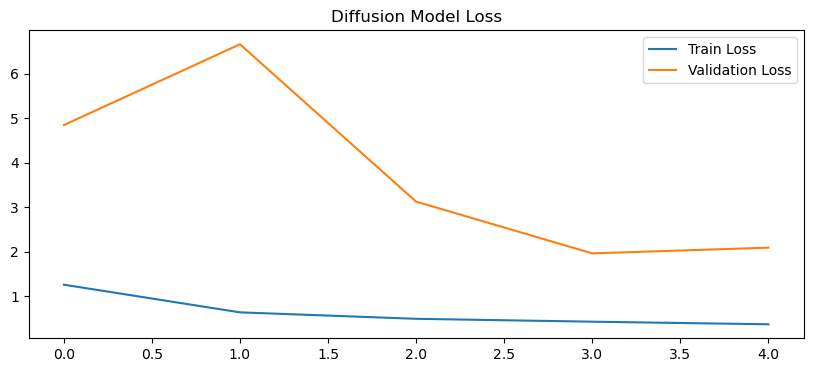

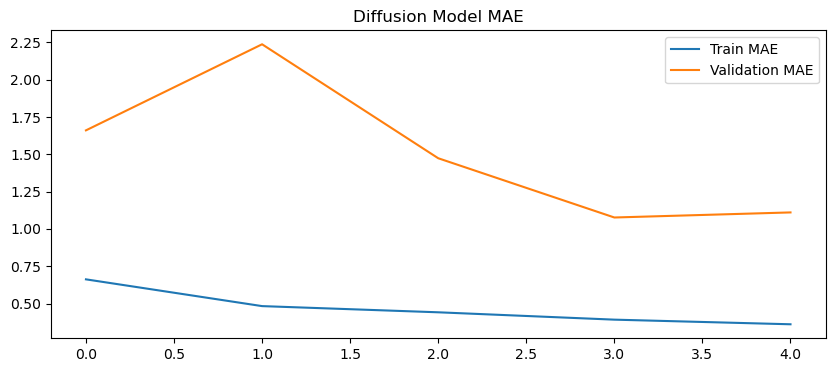

In [8]:
# Plot Diffusion Model Training History
plt.figure(figsize=(10, 4))
plt.plot(diffusion_hist.history['loss'], label='Train Loss')
plt.plot(diffusion_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Diffusion Model Loss")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(diffusion_hist.history['mae'], label='Train MAE')
plt.plot(diffusion_hist.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title("Diffusion Model MAE")
plt.show()

In [15]:
# Save the final Diffusion model
final_diffusion_model_path = os.path.join(diffusion_output_dir, "diffusion_model_final.h5")
trained_diffusion_model.save_weights(final_diffusion_model_path)
print(f"Final Diffusion model saved to {final_diffusion_model_path}")

# Save the tokenizer used by both models
tokenizer_output_path = os.path.join(diffusion_output_dir, "tokenizer")
tok.save_pretrained(tokenizer_output_path)
print(f"Tokenizer saved to {tokenizer_output_path}")

Final Diffusion model saved to ../models/diffusion/diffusion_model_final.h5
Tokenizer saved to ../models/diffusion/tokenizer


In [8]:
# ------------------------ #
# 2. Load the Transformer and Diffusion Models
# ------------------------ #

def load_transformer_model(model_name, transformer_output_dir):
    """Load the Transformer model and its tokenizer."""
    print("Loading Transformer model...")
    transformer_model = create_transformer_for_classical_style(model_name=model_name, max_length=128)
    final_model_path = os.path.join(transformer_output_dir, "auto_encoder_transformer_model_final.h5")
    transformer_model.load_weights(final_model_path)
    print(f"Transformer model loaded from {final_model_path}")

    tokenizer_output_path = os.path.join(transformer_output_dir, "tokenizer")
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_output_path)
    print(f"Tokenizer loaded from {tokenizer_output_path}")
    
    return transformer_model, tokenizer

def load_diffusion_model(input_shape, diffusion_model_params, diffusion_output_dir):
    """Load the Diffusion model and its tokenizer."""
    print("Loading Diffusion model...")
    diffusion_model = create_diffusion_model(input_shape, diffusion_model_params)
    final_diffusion_model_path = os.path.join(diffusion_output_dir, "diffusion_model_final.h5")
    diffusion_model.load_weights(final_diffusion_model_path)
    print(f"Diffusion model loaded from {final_diffusion_model_path}")

    tokenizer_output_path = os.path.join(diffusion_output_dir, "tokenizer")
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_output_path)
    print(f"Tokenizer loaded from {tokenizer_output_path}")

    return diffusion_model, tokenizer

# Reload the models
tokenizer_name = "t5-small"  # Use a Seq2Seq model
tok = AutoTokenizer.from_pretrained(tokenizer_name)

max_length = 128
max_bayt_len = 128
encoding_dim = 8
diffusion_model_params = {
    'num_transformer_blocks': 4,
    'num_heads': 8,
    'key_dim': 64,
    'ffn_units': 512
}
transformer_model, tok = load_transformer_model(tokenizer_name, transformer_output_dir)
input_shape = (max_bayt_len, encoding_dim)
diffusion_model, tok = load_diffusion_model(input_shape, diffusion_model_params, diffusion_output_dir)

Loading Transformer model...


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Transformer model loaded from ../models/transformers/auto_encoder_transformer_model_final.h5
Tokenizer loaded from ../models/transformers/tokenizer
Loading Diffusion model...
Model: "DiffusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 diffusion_input (InputLaye  [(None, 128, 8)]             0         []                            
 r)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 8)               32        ['diffusion_input[0][0]']     
 Normalization)                                                                                   
                                                                                                  
 multi_he

In [10]:
# ------------------------ #
# 3. Generate a Classical Poem
# ------------------------ #

modern_poem = (
    "إِذا الشَّعْبُ يومًا أرادَ الحياةَ فلا بُدَّ أنْ يَسْتَجيبَ "
    "القدرْ ولا بُدَّ للَّيْلِ أنْ يَنجلي ولا بُدَّ للقيدِ أن يَنْكَسِرْ "
    "ومَن لم يعانقْهُ شَوْقُ الحياةِ تَبَخَّرَ في جَوِّها واندَثَرْ "
    "فويلٌ لمَنْ لم تَشُقْهُ الحياةُ من صَفْعَةِ العَدَمِ المنتصرْ"
)

print("Generating classical poem...")

classical_poem = generate_classical_poem(
    modern_poem,
    transformer_model=transformer_model,
    tokenizer=tok,
    diffusion_model=diffusion_model,
    max_length=128
)

print("Generated Classical Poem:")
print(classical_poem)

Generating classical poem...


2024-12-31 22:47:19.434042: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5e40001240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-31 22:47:19.434127: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-12-31 22:47:19.467489: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-31 22:47:19.526568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1735703239.606268   59515 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 1s 797ms/step
Generated Classical Poem:
إِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِإِ


In [ ]:
# ------------------------ #
# 3. Generate a Poem        #
# ------------------------ #

modern_poem = (
    "إِذا الشَّعْبُ يومًا أرادَ الحياةَ فلا بُدَّ أنْ يَسْتَجيبَ "
    "القدرْ ولا بُدَّ للَّيْلِ أنْ يَنجلي ولا بُدَّ للقيدِ أن يَنْكَسِرْ "
    "ومَن لم يعانقْهُ شَوْقُ الحياةِ تَبَخَّرَ في جَوِّها واندَثَرْ "
    "فويلٌ لمَنْ لم تَشُقْهُ الحياةُ من صَفْعَةِ العَدَمِ المنتصرْ"
)

print("Generating classical poem...")

classical_poem = generate_classical_poem(
    modern_poem,
    transformer_model=trained_transformer,
    tokenizer=tok,
    diffusion_model=trained_diffusion_model,
    max_length=128
)

print("Generated Classical Poem:")
print(classical_poem)
